In [1]:
#Importing dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
from datetime import datetime as dt
from datetime import timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

### Data Preparation

In [2]:
#Reading data into a df
data = pd.read_csv("/Users/daryarudych/Desktop/Test_4.csv", sep = ';')
data.head()

,sender_id,platform_id,time_stamp,gender,reg_date
0,3207526951,6,16.03.2017 13:35,m,26.01.2017
1,3207526951,6,16.03.2017 9:09,m,26.01.2017
2,3207526951,6,16.03.2017 9:09,m,26.01.2017
3,3207526951,6,16.03.2017 12:13,m,26.01.2017
4,3207526951,6,15.03.2017 14:01,m,26.01.2017


In [3]:
#Check shape of data
print(data.shape)

#Check data types
data.dtypes

#Analyze data
data.describe(include = 'all')

#Drop rows with invalid gender
data = data[data['gender'] != ' ']
data.shape

(768439, 5)


(768268, 5)

In [4]:
#Modifying data set

#Converting time_stamp to datetime object
data['time_stamp'] = pd.to_datetime(data['time_stamp'], format = "%d.%m.%Y %H:%M")

#Label platform_id
data['platform_id'] = data['platform_id'].map({6: 'desktop', 7: 'mobile'})

#Add column with date of like
data['like_date'] = data['time_stamp'].dt.date

In [5]:
#Splitting data into before and after the test
launch = '2017-03-24 16:00'
launch_date = dt.strptime(launch, "%Y-%m-%d %H:%M")
before_df = data[data['time_stamp']<launch_date]
after_df = data[data['time_stamp']>=launch_date]

### Analysis of A/B Test Results

Так как с помощью теста мы хотим увеличить количество лайков, то в качестве KPI возьмем среднее количество лайков на одного уникального пользователя в день.

In [6]:
#Adding column with labels test/control
after_df['group'] = np.where(after_df['sender_id']%2==0, 'control', 'test')

#Add column with date of like
after_df['like_date'] = after_df['time_stamp'].dt.date

#Displaying df
after_df.head()


,sender_id,platform_id,time_stamp,gender,reg_date,like_date,group
150161,3218632174,mobile,2017-03-26 07:34:00,m,23.03.2017,2017-03-26,control
150162,3218635027,mobile,2017-03-26 06:19:00,m,23.03.2017,2017-03-26,test
150163,3218635027,mobile,2017-03-26 06:19:00,m,23.03.2017,2017-03-26,test
150164,3218635027,mobile,2017-03-26 06:18:00,m,23.03.2017,2017-03-26,test
150165,3218635027,mobile,2017-03-26 06:19:00,m,23.03.2017,2017-03-26,test


Для того, чтобы понять насколько "чисто" администрировался тест, посмотрим равномерно ли были распределены пользователи по группам.

In [7]:
results = after_df.groupby(by=['group', 'platform_id', 'gender']).agg({'sender_id': pd.Series.nunique}) 

# Find the overall number of unique users using "len" and "unique"
unique_users = len(after_df.sender_id.unique())

# Find the percentage in each group
results = round(results / unique_users * 100.2)
results

sender_id
group   platform_id gender           
control desktop     f             5.0
                    m            18.0
        mobile      f             6.0
                    m            22.0
test    desktop     f             5.0
                    m            18.0
        mobile      f             6.0
                    m            21.0

Из данной таблицы видно, что пользователи относительно равномерно распределены по группам, платформам и полам в группах.
<br>

Теперь посчитаем среднее и максимальное кол-во "лайков" на пользователя в день по каждой из групп.


In [8]:
#Grouping data by group, platform_id, like_date
aggs = {'sender_id': {'sample_size': 'nunique', 'total_likes': 'count'}}
after_df1 = after_df.groupby(['group', 'like_date']).agg(aggs)
after_df1.columns = after_df1.columns.droplevel()

#Adding column with average likes per user per day
after_df1['Avg_Likes_User'] = round(after_df.groupby(['group', 'like_date'])['sender_id'].count()/after_df.groupby('like_date')['sender_id'].nunique(),2)

#Re-grouping data to display average likes per user per day across platforms and groups
aggs1 = {'sample_size': {'sample_size': 'sum'}, 'total_likes': {'total_likes': 'sum'},'Avg_Likes_User' : {'avg_per_user/day': 'mean', 'variance': 'var'}}
summary_df = after_df1.groupby(['group']).agg(aggs1).apply(lambda x: round(x,1))
summary_df.columns = summary_df.columns.droplevel() 
summary_df['run_time'] = after_df['like_date'].max() - after_df['like_date'].min()

#Identify max clicks per group
count_likes = after_df.groupby(['group', 'platform_id','sender_id']).agg({'sender_id': {'likes': 'size'}})
count_likes.columns = count_likes.columns.droplevel()
count_likes_max = count_likes.groupby(['group'])['likes'].max()
summary_df['max_per_user'] = count_likes_max
summary_df

,sample_size,total_likes,avg_per_user/day,variance,run_time,max_per_user
group,,,,,,
control,4947,57628,5.8,0.3,3 days,1154
test,4700,49941,4.1,4.3,3 days,402


Из вышеприведенной таблицы видно, что показатели среднего кол-ва лайков на пользователя в день и максимальное кол-во лайков на пользователя у тестового варианта ниже, чем у старого. Из этих данных можно сделать предворительный вывод, что тестовый вариант не ведет к увеличению лайков. 

Однако на данном этапе нельзя с увереностью сделать вывод о том, что этот вариант хуже старого. Так как тест проводился всего 3 дня, собранных данных может быть недостаточно для того, чтобы с уверенностью отклонить этот вариант. Для того, чтобы определить является ли разница в показателях по тестовому и старому варианту статистически значимой, необходимо провести проверку гипотезы.

#### Нулевая гипотеза
Изменение кнопки "лайк" для тестовой группы не влияет на среднее кол-во "лайков" на пользователя в день.
<br>
#### Альтернативная гипотеза
Изменение кнопки "лайк" для тестовой группы ведет к увеличению/уменьшению среднего кол-ва "лайков" на пользователя в день.

In [9]:
aggs = {'time_stamp':{'total_likes':'nunique'}, 'like_date': {'count_days': 'nunique'}}
after_df2 = after_df.groupby(['sender_id', 'group'], as_index=False).agg(aggs)

after_df2.columns = after_df2.columns.droplevel(0) 
after_df2

after_df2.columns.values[0] = 'sender_id'
after_df2.columns.values[1] = 'group'
after_df2['avg_likes_user/day'] = round(after_df2['total_likes']/after_df2['count_days'],2)

control_data = after_df2[after_df2['group']=='control']
test_data = after_df2[after_df2['group']=='test']

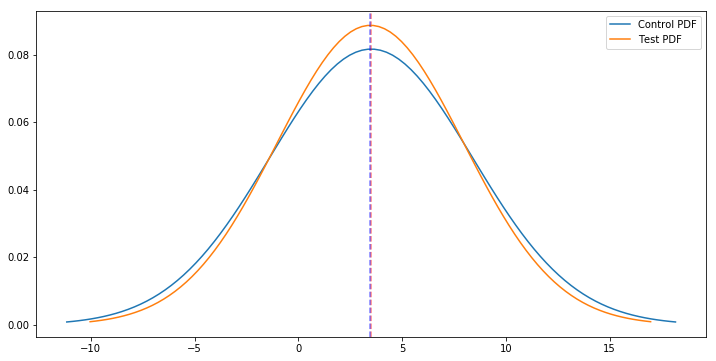

In [10]:
#Compute std for each group
control_std = np.std(control_data['avg_likes_user/day'])
test_std = np.std(test_data['avg_likes_user/day'])

#Compute means for each group
control_mean = np.mean(control_data['avg_likes_user/day'])
test_mean = np.mean(test_data['avg_likes_user/day'])


# Create the range of x values 
control_line = np.linspace( -3 * control_std+control_mean, 3 * control_std + control_mean, 100)
test_line = np.linspace( - 3 * test_std+test_mean,  3 * test_std + test_mean, 100)

# Plot the distribution 
fig, ax = plt.subplots(figsize=(12,6))

#control 
ax.plot(control_line, mlab.normpdf(control_line, control_mean, control_std), label = 'Control PDF')
ax.axvline(x=control_mean, c='red', alpha=0.5, linestyle='--')

#test
ax.plot(test_line, mlab.normpdf(test_line, test_mean, test_std), label = 'Test PDF')
ax.axvline(x=test_mean, c='blue', alpha=0.5, linestyle='--')

plt.legend(loc='upper right')
plt.show()

Как видно из графика, среднее значения для каждой из групп совпадают, в результате чего мы должны принять нулевую гипотезу. Однако, чтобы удостовериться в том, что изменение кнопки действительно не влияет на кол-во лайков, посчитаем p-value.

In [11]:
#Function to compute p-value

def get_pvalue(cont_avg, test_avg, cont_size, test_size):
    lift = - abs(test_avg-cont_avg)
    scale_one = cont_avg*(1-cont_avg)*(1/cont_size)
    scale_two = test_avg*(1-test_avg)*(1/test_size)
    scale_val = (scale_one+scale_two)**0.5
    p_value = 2*stats.norm.cdf(lift, loc=0, scale=scale_val)
    return p_value
    

In [12]:
cont_avg = control_mean
test_avg = test_mean
cont_size = len(control_data['sender_id'])
test_size = len(test_data['sender_id'])
p_value = get_pvalue(cont_avg, test_avg, cont_size, test_size)

# Check for statistical significance
if p_value >= 0.05:
    print("Разница в среднем кол-ве лайков на пользователя в день статистически незначимая")
else:
    print("Разница в среднем кол-ве лайков на пользователя в день статистически значимая")

Разница в среднем кол-ве лайков на пользователя в день статистически незначимая


#### Вывод: 
По результатам теста, можно сделать вывод, что изменение кнопки "лайк" не влияет на среднее кол-во лайков в день. Возможно тест проводился не достаточно долго и собранных данных недостаточно, чтобы увидеть изменения в кол-ве лайков.